In [24]:
import torch
from torch.cuda.amp import autocast
import numpy as np
import matplotlib.pyplot as plt

16
16
16
(10, 4, 16)
0
2
2
1
1


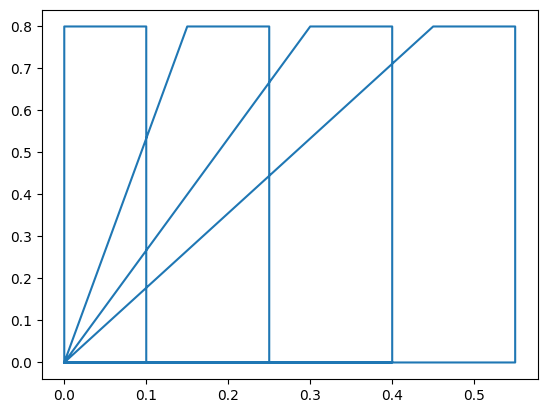

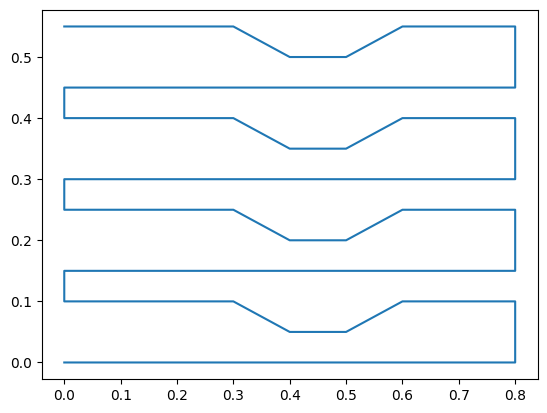

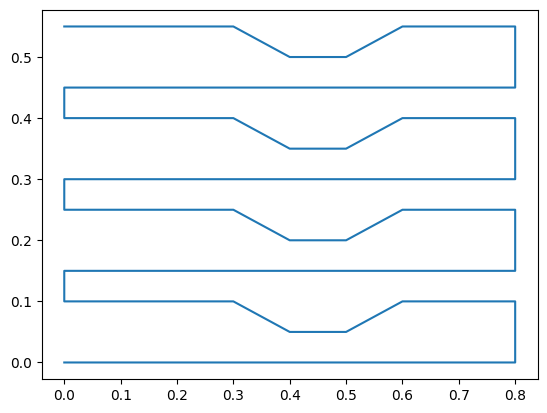

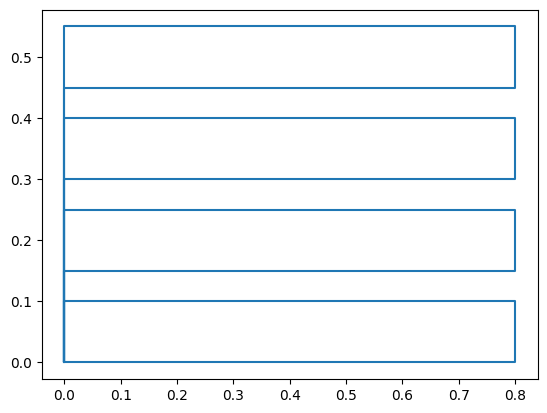

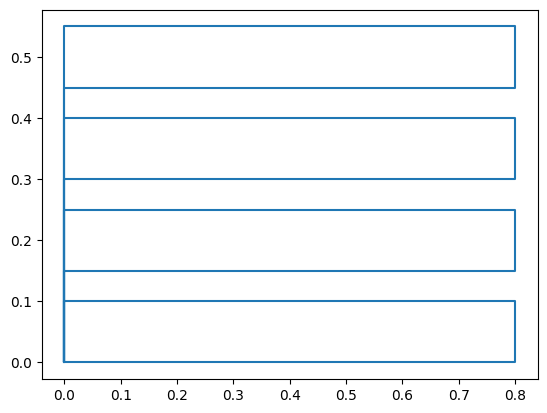

In [95]:
import random
#type1 = [0.3,0.3,0.6,0.3,0.6,0.6,0.3,0.6] # square
#type2 = [0.2,0.3,0.5,0.3,0.7,0.6,0.4,0.6] # 平行四邊形
#type3 = [0.2,0.3,0.8,0.3,0.7,0.6,0.3,0.6] # 梯形
type1 = [0.0,0.0,0.1,0.0,0.1,0.8,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
type2 = [0.0,0.0,0.8,0.0,0.8,0.1,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
type3 = [0.0,0.0,0.8,0.0,0.8,0.1,0.6,0.1,0.5,0.05,0.4,0.05,0.3,0.1,0.0,0.1]
print(len(type1))
print(len(type2))
print(len(type3))

types = [type1, type2, type3]
def pattern_gen(num=64):
  pattern_array_all = []
  label = []
  #shift = np.random.rand(num)/5
  pat_num = np.random.choice(3, num)
  scale = np.random.choice([1,2,3,4,5], num)
  for n in range(num):
    pattern_array = []
    label.append(pat_num[n])
    if pat_num[n] == 0:
      for i in range(4):
        temp_pattern = types[pat_num[n]].copy()
        for ii in range(8):
          if ii%2 == 0:
            temp_pattern[ii] += i*0.15
        pattern_array.append(temp_pattern)# / scale[n])
    elif pat_num[n] == 1:
      for i in range(4):
        temp_pattern = types[pat_num[n]].copy()
        for ii in range(8):
          if ii%2 == 1:
            temp_pattern[ii] += i*0.15
        pattern_array.append(temp_pattern) # / scale[n])
    else:
      for i in range(4):
        temp_pattern = types[pat_num[n]].copy()
        for ii in range(len(temp_pattern)):
          if ii%2 == 1:
            temp_pattern[ii] += i*0.15
        pattern_array.append(temp_pattern) # / scale[n])
    pattern_array_all.append(pattern_array)
  return np.array(pattern_array_all), np.array(label)

from matplotlib.patches import Polygon

pts, lb = pattern_gen(num=10)
print(pts.shape)
for i in range(5):
  points = np.reshape(pts[i],(-1, 2))
  print(lb[i])
  plt.figure()
  plt.plot(points[:,0], points[:,1])


In [62]:
class TransformerAE(torch.nn.Module):
  def __init__(self, in_dim, d_model):
    super(TransformerAE, self).__init__()
    self.linear1 = torch.nn.Linear(in_dim, d_model)
    self.transformer1 = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.linear3 = torch.nn.Linear(d_model, 2)
    self.linear4 = torch.nn.Linear(2, d_model)
    self.transformer2 = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=8, batch_first=True)
    self.activation = torch.nn.ReLU()
    self.linear2 = torch.nn.Linear(d_model, in_dim)

  def forward(self, x):
    x = self.linear1(x)
    x = self.activation(x)
    x = self.transformer1(x)
    x = self.linear3(x)
    x = self.linear4(x)
    x = self.transformer2(x)
    x = self.activation(x)
    x = self.linear2(x)

    return x

In [98]:
device = 'cpu'
#model = TransformerAE(in_dim=16, d_model=512).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
loss_fn = torch.nn.L1Loss()
train_loss = []
model.train()
for i in range(100):
  reconstruct, lb = pattern_gen(num=64)
  reconstruct = torch.Tensor(reconstruct)
  optimizer.zero_grad()
  with autocast():
    out = model(reconstruct.to(device))
    loss = loss_fn(out, reconstruct)
  loss.backward()
  optimizer.step()
  train_loss.append(loss.item())
  total_train_loss = sum(train_loss) / len(train_loss)
  print(f"Loss: {total_train_loss:.4f}")

<ipython-input-98-daac3422fba5>:12: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Loss: 0.1451
Loss: 0.1415
Loss: 0.1425
Loss: 0.1411
Loss: 0.1440
Loss: 0.1422
Loss: 0.1418
Loss: 0.1412
Loss: 0.1409
Loss: 0.1415
Loss: 0.1412
Loss: 0.1416


KeyboardInterrupt: 

In [99]:
from typing import Optional, Any, Union, Callable
# model = TransformerAE(in_dim=44, d_model=512).to(device)
class Model_need_weights(torch.nn.Module):
  def __init__(self, model):
    super(Model_need_weights, self).__init__()
    self.model = model
    self.model.transformer1._sa_block = self._sa_block_need_weights1
    self.model.transformer2._sa_block = self._sa_block_need_weights2

  def _sa_block_need_weights1(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer1.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer1.dropout1(x)

  def _sa_block_need_weights2(self, x: torch.Tensor, attn_mask: Optional[torch.Tensor], key_padding_mask: Optional[torch.Tensor] = None, is_causal: bool = False) -> torch.Tensor:
    x = self.model.transformer2.self_attn(x, x, x,
    attn_mask=attn_mask,
    key_padding_mask=key_padding_mask,
    need_weights=True, is_causal=is_causal)[0]

    return self.model.transformer2.dropout1(x)


model2 = Model_need_weights(model)

def forward_pass(pattern_input, model2, layers, device):
    attn_output = [[] for i in range(len(layers))]
    attn_output_weights = [[] for i in range(len(layers))]
    latent = []

    index_map = {"layer1":0, "layer2":1}
    def hook_fn_forward(module, input, output):
      ii = index_map[module.attn_name]
      attn_output[ii].append(output[0].detach().cpu())
      attn_output_weights[ii].append(output[1].detach().cpu())

    def hook_fn_forward2(module, input, output):
      latent.append(output[0].detach().cpu())

    forward_hook = [None for i in range(len(layers))]
    for i in range(len(layers)-1):
      forward_hook[i] = layers[i].register_forward_hook(hook_fn_forward)

    forward_hook[len(layers)-1] = layers[len(layers)-1].register_forward_hook(hook_fn_forward2)

    loss_fn = torch.nn.L1Loss()

    # sample subset
    random.seed(7)
    indices = range(len(pattern_input)) #random.sample(range(len(pattern_input)), 3)
    print("len(pattern_input): ", len(pattern_input))
    print(indices)
    for i in indices:
      with torch.no_grad():
        out = model2.model(pattern_input[i:i+1].to(device))
        loss = loss_fn(out, pattern_input[i:i+1])
        print("loss: ", loss)
      '''
      # output
      points = np.reshape(out[0],(-1, 2))
      plt.figure()
      plt.plot(points[:,0], points[:,1], 'o')
      # original
      points = np.reshape(pattern_input[i:i+1],(-1, 2))
      plt.figure()
      plt.plot(points[:,0], points[:,1], 'o')
      plt.show()
      '''

    for i in range(len(layers)-1):
      forward_hook[i].remove()
      attn_output[i] = torch.cat([x for x in attn_output[i]])
      attn_output_weights[i] = torch.cat([x for x in attn_output_weights[i]])

    forward_hook[len(layers)-1].remove()
    latent = torch.cat([x for x in latent])

    return attn_output, attn_output_weights, latent

layers = []
model2.model.transformer1.self_attn.attn_name = "layer1"
model2.model.transformer2.self_attn.attn_name = "layer2"
layers.append(model2.model.transformer1.self_attn)
layers.append(model2.model.transformer2.self_attn)
layers.append(model2.model.linear3)
attn_output, attn_output_weights, latent = forward_pass(reconstruct, model2, layers, device)

print(len(attn_output))
print(attn_output[0].size())
print(attn_output_weights[0].size()) # https://github.com/pytorch/pytorch/blob/main/torch/nn/functional.py # attn_output_weights = torch.bmm(q_scaled, k.transpose(-2, -1)) # # optionally average attention weights over heads

len(pattern_input):  64
range(0, 64)
loss:  tensor(0.1240)
loss:  tensor(0.0808)
loss:  tensor(0.2114)
loss:  tensor(0.2052)
loss:  tensor(0.1275)
loss:  tensor(0.2086)
loss:  tensor(0.0802)
loss:  tensor(0.2115)
loss:  tensor(0.1226)
loss:  tensor(0.1233)
loss:  tensor(0.1328)
loss:  tensor(0.0787)
loss:  tensor(0.0818)
loss:  tensor(0.0857)
loss:  tensor(0.0785)
loss:  tensor(0.2163)
loss:  tensor(0.1213)
loss:  tensor(0.1249)
loss:  tensor(0.0814)
loss:  tensor(0.2092)
loss:  tensor(0.1235)
loss:  tensor(0.0784)
loss:  tensor(0.1291)
loss:  tensor(0.2173)
loss:  tensor(0.2070)
loss:  tensor(0.2135)
loss:  tensor(0.1275)
loss:  tensor(0.0757)
loss:  tensor(0.0800)
loss:  tensor(0.0842)
loss:  tensor(0.0779)
loss:  tensor(0.1260)
loss:  tensor(0.1297)
loss:  tensor(0.1268)
loss:  tensor(0.0786)
loss:  tensor(0.1280)
loss:  tensor(0.0789)
loss:  tensor(0.0774)
loss:  tensor(0.0799)
loss:  tensor(0.0839)
loss:  tensor(0.0735)
loss:  tensor(0.1233)
loss:  tensor(0.2101)
loss:  tensor(0.1

torch.Size([4, 512])
torch.Size([4, 512])
torch.Size([256, 2])


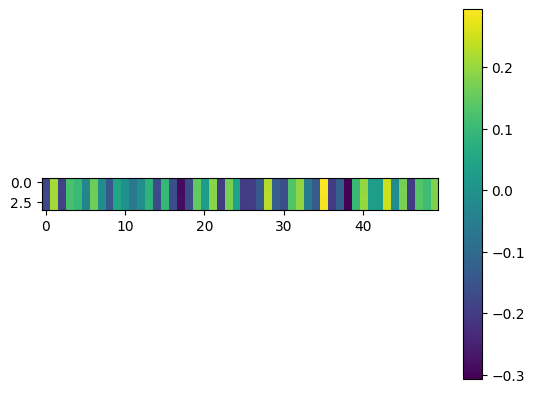

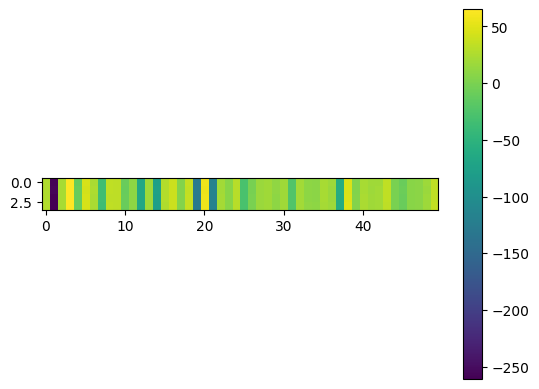

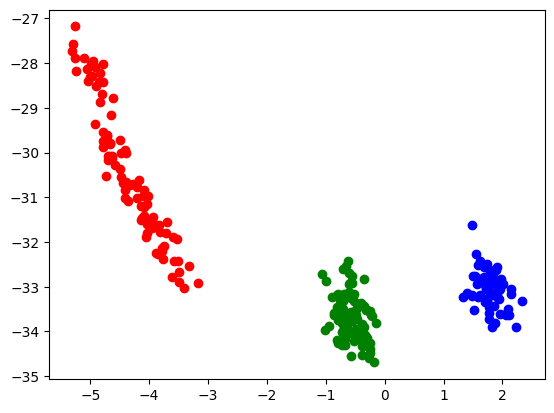

In [104]:
for i in range(len(layers)-1):
  attn_output_weights_avg = torch.mean(attn_output[i], dim=0)
  print(attn_output_weights_avg.size())
  plt.figure()
  plt.imshow(attn_output_weights_avg[:,0:50])
  plt.colorbar()

print(latent.size())
latent.reshape((-1,2))
plt.figure()
colors = ['r','g','b']
for i in range(3):
  latent_temp = np.array([lt for ii,lt in enumerate(latent) if lb[ii//attn_output_weights_avg.size()[0]] == i])
  plt.scatter(latent_temp[:,0], latent_temp[:,1], c=colors[i])


torch.Size([256, 2])
256
2 [0 0 0 0 1 1 1 1 2 2 2 2 2 2 2 2 0 0 0 0 2 2 2 2 1 1 1 1 2 2 2 2 0 0 0 0 0
 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 0 0 0 0 0 0 0 0 1 1
 1 1 2 2 2 2 0 0 0 0 1 1 1 1 0 0 0 0 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 2 2 1 1 1 1 0 0 0 0 2 2 2 2 1 1 1 1 2 2 2 2 0 0 0 0 2 2 2 2 0 0 0 0 2 2
 2 2 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1]


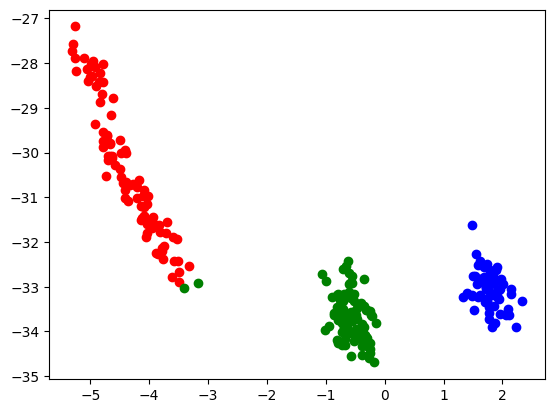

In [107]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(latent)
print(latent.size())
print(len(kmeans.labels_))
print(max(kmeans.labels_), kmeans.labels_)
for i in range(3):
  latent_temp = np.array([lt for ii,lt in enumerate(latent) if kmeans.labels_[ii] == i])
  plt.scatter(latent_temp[:,0], latent_temp[:,1], c=colors[i])